In [1]:
import os
import time
import torch

from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder  # For encoding class labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set the device to use (GPU or CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using *{device}* device")

c:\Users\yashs\miniconda3\envs\learn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using *cuda* device


In [2]:
# Load the dataset from a CSV file
df1 = pd.read_json('data/sarcasm-headlines/Sarcasm_Headlines_Dataset.json', lines=True).drop(columns=['article_link'])
df2 = pd.read_json('data/sarcasm-headlines/Sarcasm_Headlines_Dataset_v2.json', lines=True).drop(columns=['article_link'])

# Concatenate the two datasets
data_df = pd.concat([df1, df2], ignore_index=True)
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)

print(data_df.head())
print(data_df.shape)
print(f"\nThere are {data_df.is_sarcastic.nunique()} unique classes in the dataset: {data_df.is_sarcastic.unique()}")

                                            headline  is_sarcastic
0  former versace store clerk sues over secret 'b...             0
1  the 'roseanne' revival catches up to our thorn...             0
2  mom starting to fear son's web series closest ...             1
3  boehner just wants wife to listen, not come up...             1
4  j.k. rowling wishes snape happy birthday in th...             0
(28503, 2)

There are 2 unique classes in the dataset: [0 1]


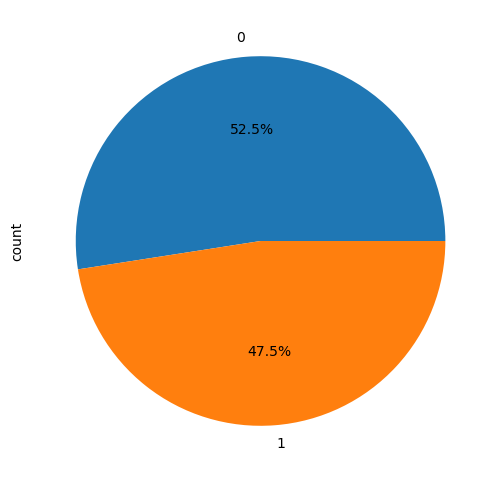

In [3]:
data_df.is_sarcastic.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 6));

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data_df['headline'], data_df['is_sarcastic'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((19952,), (4275,), (4276,))

In [5]:
# Define the tokenizer for preprocessing the text data

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')
bert_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
class CustomTextDataset(Dataset):
    def __init__(self, X, y):
        self.X = [tokenizer(text, max_length=100, padding='max_length', truncation=True, return_tensors='pt').to(device) for text in X]
        self.y = torch.tensor(y.values).float().to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = CustomTextDataset(X_train, y_train)
test_dataset = CustomTextDataset(X_test, y_test)
val_dataset = CustomTextDataset(X_val, y_val)

# val_dataset.__getitem__(0)

In [7]:
class Net(nn.Module):
    def __init__(self, bert):
        super().__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, tokens):
        pooled_output = self.bert(tokens['input_ids'].squeeze(1), tokens['attention_mask'].squeeze(1), return_dict=False)[0][:, 0]
        
        x = self.linear1(pooled_output)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        
        return x

## Transfer Learning

In [ ]:
LR = 1e-4
EPOCHS = 10
BATCH_SIZE = 512

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
for params in bert_model.parameters():
    params.requires_grad = False

model = Net(bert_model)
model.to(device)

{'input_ids': tensor([[ 101, 3842, 7568, 2005, 2070, 9577, 1047, 1011, 3769, 4485, 2076, 3098,
         5103,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epoch_times = []

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train_acc = 0
    val_loss = val_acc = 0

    for tokens, labels in train_loader:
        outputs = model(tokens).squeeze(1)

        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        train_acc += (outputs.round() == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(round(train_loss / 1000, 4))
    train_accuracies.append(round((train_acc / len(train_dataset)) * 100, 4))


    with torch.no_grad():
        for tokens, labels in val_loader:
            outputs = model(tokens).squeeze(1)

            val_loss += loss_fn(outputs, labels).item()
            val_acc += (outputs.round() == labels).sum().item()

    val_losses.append(round(val_loss / 1000, 4))
    val_accuracies.append(round((val_acc / len(val_dataset)) * 100, 4))


    print(f'Epoch: {epoch + 1} / {EPOCHS} | Training loss: {train_losses[-1]:.4f} | Validation loss: {val_losses[-1]:.4f} | Training accuracy: {train_accuracies[-1]:.2f}% | Validation accuracy: {val_accuracies[-1]:.2f}% | Epoch Time: {time.time() - start_time: .2f}s')

print(f'Training complete!')

Epoch: 1 / 10 | Training loss: 0.0167 | Validation loss: 0.0038 | Training accuracy: 81.89% | Validation accuracy: 82.08% | Epoch Time:  70.31s
Epoch: 2 / 10 | Training loss: 0.0157 | Validation loss: 0.0037 | Training accuracy: 82.91% | Validation accuracy: 82.76% | Epoch Time:  70.31s
Epoch: 3 / 10 | Training loss: 0.0150 | Validation loss: 0.0035 | Training accuracy: 83.70% | Validation accuracy: 83.02% | Epoch Time:  70.91s
Epoch: 4 / 10 | Training loss: 0.0145 | Validation loss: 0.0035 | Training accuracy: 84.14% | Validation accuracy: 83.32% | Epoch Time:  70.80s
Epoch: 5 / 10 | Training loss: 0.0141 | Validation loss: 0.0034 | Training accuracy: 84.50% | Validation accuracy: 83.32% | Epoch Time:  70.39s
Epoch: 6 / 10 | Training loss: 0.0138 | Validation loss: 0.0034 | Training accuracy: 84.87% | Validation accuracy: 83.34% | Epoch Time:  70.25s
Epoch: 7 / 10 | Training loss: 0.0135 | Validation loss: 0.0033 | Training accuracy: 85.24% | Validation accuracy: 83.79% | Epoch Time: 

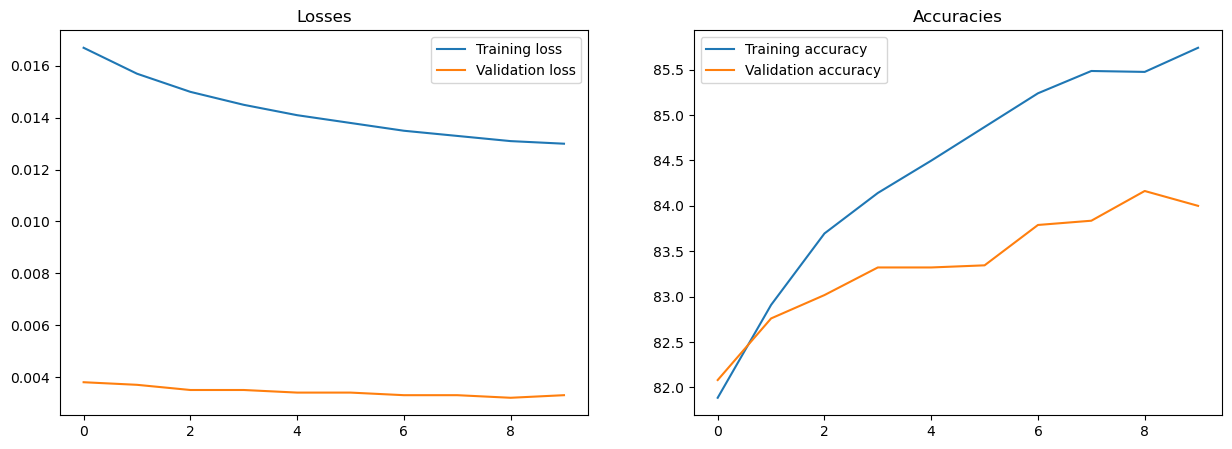

In [13]:
# Subplots for losses and accuracies
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_losses, label='Training loss')
axs[0].plot(val_losses, label='Validation loss')
axs[0].set_title('Losses')
axs[0].legend()

axs[1].plot(train_accuracies, label='Training accuracy')
axs[1].plot(val_accuracies, label='Validation accuracy')
axs[1].set_title('Accuracies')
axs[1].legend()
plt.show()

In [18]:
test_acc = 0

with torch.no_grad():
    for tokens, labels in test_loader:
        outputs = model(tokens).squeeze(1)
        
        test_acc += (outputs.round() == labels).sum().item()

print(f'Test set: Accuracy: {(test_acc / len(test_dataset)) * 100:.2f}%')

Test set: Accuracy: 84.42%


## Complete Model Training

In [8]:
LR = 1e-4
EPOCHS = 10
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
for params in bert_model.parameters():
    params.requires_grad = True

new_model = Net(bert_model)
new_model.to(device)

Net(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [10]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=LR)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epoch_times = []

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train_acc = 0
    val_loss = val_acc = 0

    for tokens, labels in train_loader:
        outputs = new_model(tokens).squeeze(1)

        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        train_acc += (outputs.round() == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(round(train_loss / 1000, 4))
    train_accuracies.append(round((train_acc / len(train_dataset)) * 100, 4))


    with torch.no_grad():
        for tokens, labels in val_loader:
            outputs = new_model(tokens).squeeze(1)

            val_loss += loss_fn(outputs, labels).item()
            val_acc += (outputs.round() == labels).sum().item()

    val_losses.append(round(val_loss / 1000, 4))
    val_accuracies.append(round((val_acc / len(val_dataset)) * 100, 4))


    print(f'Epoch: {epoch + 1} / {EPOCHS} | Training loss: {train_losses[-1]:.4f} | Validation loss: {val_losses[-1]:.4f} | Training accuracy: {train_accuracies[-1]:.2f}% | Validation accuracy: {val_accuracies[-1]:.2f}% | Epoch Time: {time.time() - start_time: .2f}s')

print(f'Training complete!')

Epoch: 1 / 10 | Training loss: 0.0733 | Validation loss: 0.0136 | Training accuracy: 90.20% | Validation accuracy: 91.79% | Epoch Time:  188.72s
Epoch: 2 / 10 | Training loss: 0.0196 | Validation loss: 0.0150 | Training accuracy: 97.81% | Validation accuracy: 92.21% | Epoch Time:  189.23s
Epoch: 3 / 10 | Training loss: 0.0081 | Validation loss: 0.0219 | Training accuracy: 99.20% | Validation accuracy: 92.30% | Epoch Time:  190.02s
Epoch: 4 / 10 | Training loss: 0.0075 | Validation loss: 0.0236 | Training accuracy: 99.19% | Validation accuracy: 91.67% | Epoch Time:  192.68s
Epoch: 5 / 10 | Training loss: 0.0052 | Validation loss: 0.0249 | Training accuracy: 99.45% | Validation accuracy: 92.12% | Epoch Time:  192.66s
Epoch: 6 / 10 | Training loss: 0.0042 | Validation loss: 0.0216 | Training accuracy: 99.50% | Validation accuracy: 91.95% | Epoch Time:  193.41s
Epoch: 7 / 10 | Training loss: 0.0050 | Validation loss: 0.0248 | Training accuracy: 99.46% | Validation accuracy: 91.88% | Epoch 

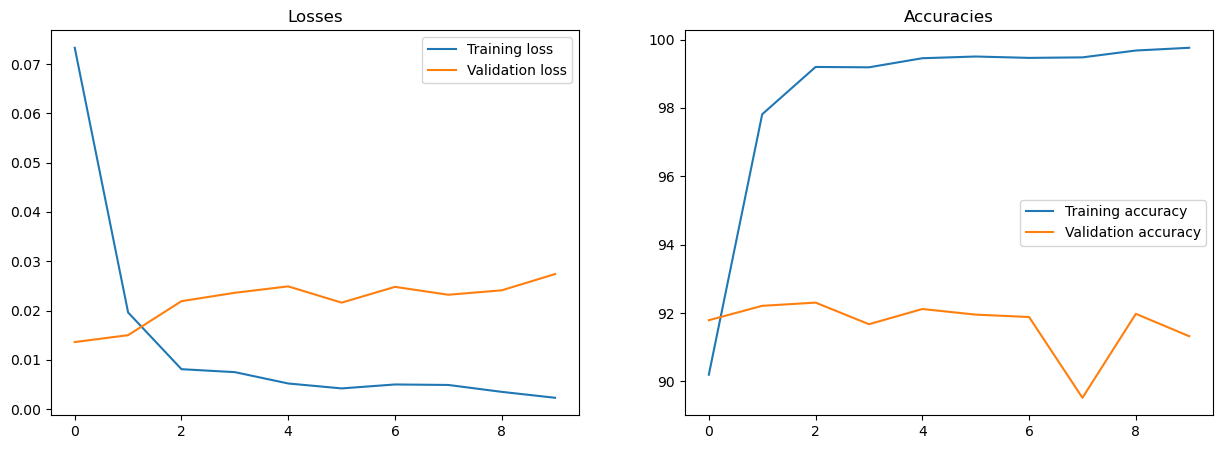

In [11]:
# Subplots for losses and accuracies
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_losses, label='Training loss')
axs[0].plot(val_losses, label='Validation loss')
axs[0].set_title('Losses')
axs[0].legend()

axs[1].plot(train_accuracies, label='Training accuracy')
axs[1].plot(val_accuracies, label='Validation accuracy')
axs[1].set_title('Accuracies')
axs[1].legend()
plt.show()

In [ ]:
test_acc = 0

with torch.no_grad():
    for tokens, labels in test_loader:
        outputs = new_model(tokens).squeeze(1)
        
        test_acc += (outputs.round() == labels).sum().item()

print(f'Test set Accuracy: {(test_acc / len(test_dataset)) * 100:.2f}%')

Test set Accuracy: 90.72%


: 